<a href="https://colab.research.google.com/github/JSJeong-me/YOLOX/blob/main/Train_YOLOX_on_a_Custom_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train YOLOX on Custom Objects

This tutorial is based on the [YOLOX repository](https://github.com/Megvii-BaseDetection/YOLOX) by [the Megvii Team](https://github.com/Megvii-BaseDetection). This notebook shows training on **your own custom objects**. Many thanks to the Megvii Team for putting this repository together - we hope that in combination with clean data management tools at Roboflow, this technologoy will become easily accessible to any developer wishing to use computer vision in their projects.

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [How to Train YOLOX](blog.roboflow.com/how-to-train-yolox-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train YOLOR on your custom objects. We use a [public blood cell detection dataset](https://public.roboflow.ai/object-detection/bccd), which is open source and free to use. You can also use this notebook on your own data. We will use Roboflow to preprocess our images.

To train our detector we take the following steps:

* Install YOLOX dependencies
* Download and Prepare custom YOLOX object detection data
* Download Pre-Trained Weights for YOLOX
* Run YOLOX training
* Evaluate YOLOX performance
* Run YOLOX inference on test images
* Export saved YOLOX weights for future inference

### **About**

[Roboflow](https://roboflow.com) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

**Looking for a vision model available via API without hassle? Try Roboflow Train.**

![Roboflow Wordmark](https://i.imgur.com/dcLNMhV.png)

# Install YOLOX Dependencies

In [ ]:
!git clone https://github.com/roboflow-ai/YOLOX.git
%cd YOLOX
!pip3 install -U pip && pip3 install -r requirements.txt
!pip3 install -v -e .  
!pip uninstall -y torch torchvision torchaudio
# May need to change in the future if Colab no longer uses CUDA 11.0
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

## Install Nvidia Apex

In [ ]:
%cd /content/
!git clone https://github.com/NVIDIA/apex
%cd apex
!pip install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

## Install PyCocoTools

In [ ]:
!pip3 install cython; pip3 install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# Download your Data

We'll download our dataset from Roboflow. Use the "**Pascal VOC**" export format.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).


In [ ]:
#to get your roboflow code below please follow the link output by this cell
!pip -q install roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="voc", notebook="yolox")

In [ ]:
%cd /content/
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="cBvA3AswvNvCnZPiGV0J")
project = rf.workspace().project("bccd-4oqnh")
dataset = project.version(1).download("voc")

In [10]:
!pwd

/content/YOLOX


In [17]:
%cd /content/

/content


In [18]:
%cd YOLOX/
!ln -s {dataset.location}/train/ ./datasets/VOCdevkit

/content/YOLOX


## Format Your Data Appropriately

In [19]:
%mkdir "/content/YOLOX/datasets/VOCdevkit/VOC2007"
!python3 voc_txt.py "/content/YOLOX/datasets/VOCdevkit/"
%mkdir "/content/YOLOX/datasets/VOCdevkit/VOC2012"
!cp -r "/content/YOLOX/datasets/VOCdevkit/VOC2007/." "/content/YOLOX/datasets/VOCdevkit/VOC2012"

train and val size: 688
train size: 550


## Change the Classes
Make sure you change the classes based on what your dataset. To ensure that the training process will function as intended, write the classes in lowercase with no whitespace.

In [20]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [21]:
##REPLACE this cell with your classnames stripped of whitespace and lowercase
%%writetemplate /content/YOLOX/yolox/data/datasets/voc_classes.py

VOC_CLASSES = (
  "rbc",
  "wbc",
  "platelets"
)

Set the number of classes you have in your dataset in te `NUM_CLASSES` variable

In [23]:
NUM_CLASSES = 3
!sed -i -e 's/self.num_classes = 20/self.num_classes = {NUM_CLASSES}/g' "/content/YOLOX/exps/example/yolox_voc/yolox_voc_s.py"

# Download Pretrained Weights

In [ ]:
%cd /content/
!wget https://github.com/Megvii-BaseDetection/storage/releases/download/0.0.1/yolox_s.pth
%cd /content/YOLOX/

# Train the Model

In [ ]:
!python tools/train.py -f exps/example/yolox_voc/yolox_voc_s.py -d 1 -b 16 --fp16 -o -c /content/yolox_s.pth

# Evaluate the Model

In [ ]:
MODEL_PATH = "/content/YOLOX/YOLOX_outputs/yolox_voc_s/latest_ckpt.pth.tar"
!python3 tools/eval.py -n  yolox-s -c {MODEL_PATH} -b 64 -d 1 --conf 0.001 -f exps/example/yolox_voc/yolox_voc_s.py

# Test the Model
Make sure you replace the `TEST_IMAGE_PATH` variable with a test image from your dataset

In [ ]:
TEST_IMAGE_PATH = "/content/BCCD-1/test/BloodImage_00038_jpg.rf.278fad84d7d36eab58205fa1de4eafbc.jpg"
!python tools/demo.py image -f /content/YOLOX/exps/example/yolox_voc/yolox_voc_s.py -c {MODEL_PATH} --path {TEST_IMAGE_PATH} --conf 0.25 --nms 0.45 --tsize 640 --save_result --device gpu

# Visualize the Predictions
Make sure you replace the `OUTPUT_IMAGE_PATH` with the respective path of the image output. This path can be found somewhere in the `YOLOX_outputs` folder


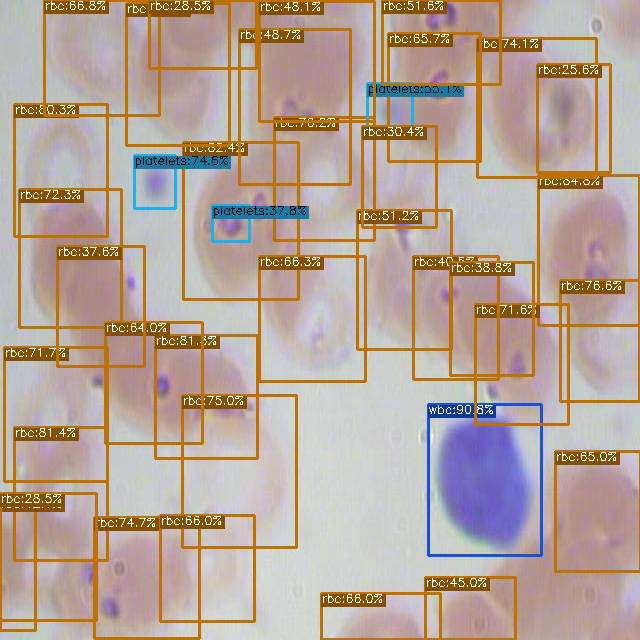

In [28]:
from PIL import Image
OUTPUT_IMAGE_PATH = "/content/YOLOX/YOLOX_outputs/yolox_voc_s/vis_res/2021_10_17_02_41_27/BloodImage_00038_jpg.rf.278fad84d7d36eab58205fa1de4eafbc.jpg" 
Image.open(OUTPUT_IMAGE_PATH)

# Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cp {MODEL_PATH} /content/gdrive/My\ Drive